In [1]:
# preprocessing imports
import pandas as pd
import numpy as np
from itertools import *
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import re

# training imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Data Investigation

In [2]:
test_investigate = pd.read_csv('test.csv')
train_investigate = pd.read_csv('train.csv').iloc[:, 1:]
train_investigate.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing Data

The training data and test data are similar in that the `Cabin` and `Age` features have lots of missing values.

Considering that `Cabin` has over three fourths of the data missing, it will not be a good feature to predict on.

`Age`, `Embarked`, and `Fare` can potentially still be useful features.

In [3]:
percent_missing_train = train_investigate.isnull().sum() * 100 / train_investigate.shape[0]
np.round(percent_missing_train[percent_missing_train > 0].sort_values(ascending=False), 2)

Cabin       77.10
Age         19.87
Embarked     0.22
dtype: float64

In [4]:
percent_missing_test = test_investigate.isnull().sum() * 100 / test_investigate.shape[0]
np.round(percent_missing_test[percent_missing_test > 0].sort_values(ascending=False), 2)

Cabin    78.23
Age      20.57
Fare      0.24
dtype: float64

## Pclass

People in first class on average survived at a higher rate.

In [5]:
train_investigate.groupby('Pclass').mean()[['Survived']]

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [6]:
train_investigate['Pclass3'] = (train_investigate['Pclass'] == 3) * 1
test_investigate['Pclass3'] = (test_investigate['Pclass'] == 3) * 1

## Name

People who had a unique title in their name were more likely to survive than people who did not

In [7]:
def name_title(name):
    pattern = r'(\w+)\.'
    title = re.search(pattern, name)
    if title:
        return title.group(1)
    return ""

title_counts = train_investigate['Name'].apply(name_title).value_counts()
title_counts

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Name, dtype: int64

In [8]:
train_investigate['Title'] = train_investigate['Name'].apply(name_title)
test_investigate['Title'] = test_investigate['Name'].apply(name_title)
title_counts = train_investigate['Title'].value_counts()
important_titles = list(title_counts[title_counts <= 500].index)
train_investigate['CommonTitle'] = 1 - train_investigate['Title'].isin(important_titles) * 1
test_investigate['CommonTitle'] = 1 - test_investigate['Title'].isin(important_titles) * 1
display(train_investigate.groupby('CommonTitle').mean()[['Survived']].sort_values(by='Survived'))
train_investigate['CommonTitle'].value_counts()

,Survived
CommonTitle,
1,0.156673
0,0.697861


1    517
0    374
Name: CommonTitle, dtype: int64

## Sex

Women were much more likely to survive than men

In [9]:
binary_sex = lambda row: 1 if row == 'female' else 0
train_investigate['Female'] = train_investigate['Sex'].apply(binary_sex)
test_investigate['Female'] = test_investigate['Sex'].apply(binary_sex)
train_investigate.groupby('Female').mean()[['Survived']]

,Survived
Female,
0,0.188908
1,0.742038


## Age

On average, children were more likely to survive than adults.

In [10]:
age_dict = train_investigate.groupby('Title').median()['Age'].to_dict()
train_investigate['Age'] = train_investigate['Age'].fillna(train_investigate['Pclass'].map(age_dict))
test_investigate['Age'] = test_investigate['Age'].fillna(test_investigate['Pclass'].map(age_dict))

In [11]:
train_investigate['Adult'] = (train_investigate['Age'] >= 16) * 1
test_investigate['Adult'] = (test_investigate['Age'] >= 16) * 1
display(train_investigate.groupby('Adult').mean()[['Survived']].sort_values(by='Survived'))
train_investigate['Adult'].value_counts()

,Survived
Adult,
1,0.381933
0,0.388462


1    631
0    260
Name: Adult, dtype: int64

## Sibling, Spouse, Parent, Children

People in families with 1-3 others were the most likely to survive

In [12]:
train_investigate['CommonFamilySize'] = train_investigate['SibSp'] + train_investigate['Parch']
test_investigate['CommonFamilySize'] = test_investigate['SibSp'] + test_investigate['Parch']
display(train_investigate.groupby('CommonFamilySize').mean()[['Survived']].head(5))
family_size_train = (train_investigate['CommonFamilySize'] > 0) & (train_investigate['CommonFamilySize'] < 4)
family_size_test = (test_investigate['CommonFamilySize'] > 0) & (test_investigate['CommonFamilySize'] < 4)
train_investigate['CommonFamilySize'] = 1 - family_size_train 
test_investigate['CommonFamilySize'] = 1 - family_size_test
display(train_investigate.groupby('CommonFamilySize').mean()[['Survived']].sort_values(by='Survived'))
train_investigate['CommonFamilySize'].value_counts()

,Survived
CommonFamilySize,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000


,Survived
CommonFamilySize,
1,0.288815
0,0.578767


1    599
0    292
Name: CommonFamilySize, dtype: int64

## Fare

People who paid more for their ticket had a higher chance of surviving on average.

In [13]:
display(train_investigate.groupby('Pclass').median()[['Fare']])
fare_dict = {1:60.3, 2:14.3, 3:8.0}
test_investigate['Fare'] = test_investigate['Fare'].fillna(test_investigate['Pclass'].map(fare_dict))

,Fare
Pclass,
1,60.2875
2,14.2500
3,8.0500


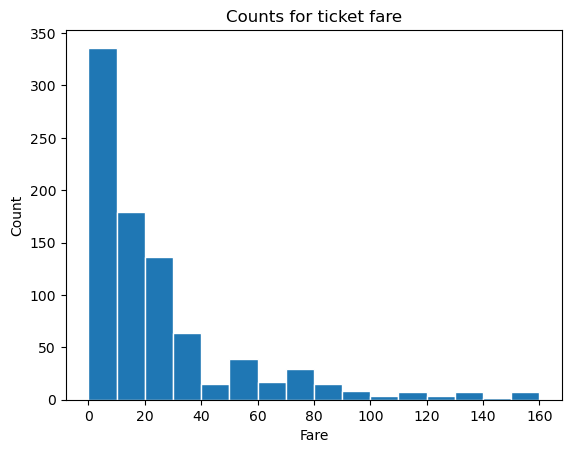

In [14]:
plt.hist(train_investigate['Fare'], ec='white', bins=np.arange(0, 161, 10))
plt.ylabel('Count')
plt.xlabel('Fare')
plt.title('Counts for ticket fare');

In [15]:
train_investigate['HighFare'] = (train_investigate['Fare'] > 10) * 1
test_investigate['HighFare'] = (test_investigate['Fare'] > 10) * 1
display(train_investigate.groupby('HighFare').mean()[['Survived']].sort_values(by='Survived', ascending=False))
train_investigate['HighFare'].value_counts()

,Survived
HighFare,
1,0.495495
0,0.199405


1    555
0    336
Name: HighFare, dtype: int64

## Embarked

People who embarked from port C had the highest chance of survival, and people who embarked from port S had the lowest chance of survival

In [16]:
display(train_investigate['Embarked'].value_counts())
display(train_investigate.groupby('Embarked').mean()[['Survived']])
train_investigate['Embarked'] = train_investigate['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [17]:
train_investigate['EmbarkedGroup'] = 1 - ((train_investigate['Embarked'] == 'C')) * 1
test_investigate['EmbarkedGroup'] = 1 - ((test_investigate['Embarked'] == 'C')) * 1
train_investigate['Pclass1'] = (train_investigate['Pclass'] == 1) * 1
test_investigate['Pclass1'] = (test_investigate['Pclass'] == 1) * 1

## Drop Unused Features

In [18]:
unused_features_investigate = [
    'Cabin', 'Name', 'Sex', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Age', 'Pclass', 'Embarked', 'Title'
]
train = train_investigate.copy(deep=True).drop(unused_features_investigate, axis=1)
test = test_investigate.copy(deep=True).drop(unused_features_investigate, axis=1)
display(train.head(3)), display(test.head(3))

,Survived,Pclass3,CommonTitle,Female,Adult,CommonFamilySize,HighFare,EmbarkedGroup,Pclass1
0,0,1,1,0,1,0,0,1,0
1,1,0,0,1,1,0,1,0,1
2,1,1,0,1,1,1,0,1,0


,PassengerId,Pclass3,CommonTitle,Female,Adult,CommonFamilySize,HighFare,EmbarkedGroup,Pclass1
0,892,1,1,0,1,1,0,1,0
1,893,1,0,1,1,0,0,1,0
2,894,0,1,0,1,1,0,1,0


(None, None)

# Data Preprocessing

In [19]:
def process_data(df):
    pca = PCA()
    return pca.fit_transform(df)

def train_validation_split(df, seed=None, size=0.85):
    X, Y = df.iloc[:, 1:], df['Survived']
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=size, random_state=seed)
    X_train, X_val = process_data(X_train), process_data(X_val)
    return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = train_validation_split(train, seed=42, size=0.90)

# Hyperparameter Tuning MLP Classifier

In [20]:
def get_accuracy(clf, X, Y):
    Y_preds = clf.predict(X)
    score = accuracy_score(Y_preds, Y)
    return np.round(score, 4)
    
best_accuracy, best_clf = 0, None
solvers = ['lbfgs', 'sgd', 'adam']

for solver in solvers:
    clf = MLPClassifier(
        activation = 'identity',
        solver = solver,
        random_state = 42
    )
    clf.fit(X_train, Y_train)
    accuracy = get_accuracy(clf, X_val, Y_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_clf = clf

best_accuracy, best_clf.activation, best_clf.solver

(0.7667, 'identity', 'sgd')

# Prediction on test set

In [21]:
def predict(best_classifier, save=False):
    passenger_id = test['PassengerId']
    X_test = process_data(test.iloc[:, 1:])
    Y_pred_test = clf.predict(X_test)
    output = pd.DataFrame(np.array([passenger_id, Y_pred_test]).T, columns=['PassengerId', 'Survived'])
    output = output.set_index('PassengerId')
    if save:
        output.to_csv('Predictions.csv')
    return output

predict(best_clf, save=True)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
